# Study: Can we predict the value of a house in Calgary?
This question came to mind when I was having a discussion with my mom (a real-estate agent) about the process of buying real estate in Calgary. 

When coming up with a listing price, a real-estate agent will conduct the appraisal process by employing a variety of methods; the most common appraisal method for houses is the *sales comparison approach.* The process is pretty intuitive: grab a list of comparables (i.e., properties that were sold and have similar features to the current one) from a database along with other pieces of information about the house (e.g., size of lot, number of bedrooms etc.), and extrapolate the price from the data.

The real-estate agent and client will then discuss and come up with a listing price. However, the true value of the house is still unknown, and may be far off from the listed price due to a variety of unknown reasons. For this reason, can a statistical model be used to predict housing prices accurately given similar information?

This analysis may be a great tool for all parties in a transaction: real-estate agents and sellers could use this information to be assured of their listing price, and buyers can determine whether or not the current estate is under/over-valued. 

# Data Collection

First, let's try to find any data sources available. Because we're attempting to predict a given house's price, we'd want a data source containing exactly that. Fortunately, *AlbertaRE* recently released housing data containing sold prices with a time horizon of 2 years. We can use this to form the basis of our dataset.

## Dataset Creation

To access the data, we can either scrape the data from the HTML itself using an automated browser tool such as **Selenium** and access the information we need via the **BeautifulSoup** library, or, we can directly query the website's API to gain access to the information in JSON format using the **requests** module. I chose the latter for its easier approach.

In [4]:
import requests
import json
import pandas as pd
from tqdm import tqdm
import IPython
import pickle
import re

import warnings
warnings.filterwarnings('ignore')

The website has an authentication wall, so we can use the ``Session`` object from the requests module to have persistent cookies when we scrape the data.

In [2]:
# Login info
EMAIL = 'EMAIL'
PHONE = 'PHONE'

# URL for login
LOGIN_URL = 'https://search.albertare.com/api/leads/login'

# URL for listing ids
LISTINGS_REQ_URL = 'https://search.albertare.com/api/properties'

# URL for listing info
REQUEST_URL = 'https://search.albertare.com/api/properties/'

In [3]:
# Start session for cookie header
s = requests.Session()

# Set appropriate headers (copied from browser)
headers = {
    'accept': 'application/json, text/plain, */*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'content-type': 'application/json',
    'origin': 'https://search.albertare.com',
    'referer': 'https://search.albertare.com/real-estate/calgary_ab/status-sold/from-200000?city=Calgary&headline=Log%20In%20on%20Top%20Menu%20To%20See%20Sold%20Properties',
    'sec-ch-ua': '"Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36',
    'x-requested-with': 'XMLHttpRequest',
    'Connection': 'keep-alive' # Don't drop connection!
}

login_data = {
    'lead': {
        'email': EMAIL,
        'phone': PHONE
    }
}

# Convert payload to JSON
login_json = json.dumps(login_data)

# Login to website
r = s.post(LOGIN_URL, data=login_json, headers=headers)

Now, we can request data from the server's API to grab information on the sold properties. Since the study pertains to Calgary, we just use the params object to filter our search.

In [4]:
# Grab meta information to get number of pages

# Add authorization
headers['authorization'] = 'Bearer ' + r.json()['data']['token']

# Query string for populating filters
query = {
    'status': 's', # assume sold?
    'city': 'Calgary',
    'headline': 'Log%20In%20on%20Top%20Menu%20To%20See%20Sold%20Properties',
    'cf_ds': 'created_at%20desc',
    'cf_ua': '1',
    'cf_hs': '1',
    'page': '2'
}

# Access first page to get total pages
r = s.get(LISTINGS_REQ_URL, params=query, headers=headers)
num_pages = r.json()['meta']['pagination']['total_pages']

Next, we want to create a dataframe containing each house's attributes that we can use to perform regression.

In [ ]:
dfs = [] # For final df

# Features that may be important
features = ['id', 'attributes.listed_at', 'attributes.mls', 
            'attributes.street', 'attributes.address', 'attributes.city',
            'attributes.state', 'attributes.zip', 'attributes.neighborhood',
            'attributes.area', 'attributes.county', 'attributes.price',
            'attributes.type', 'attributes.description', 'attributes.bedrooms',
            'attributes.bathrooms', 'attributes.half_bathrooms', 'attributes.square',
            'attributes.lot_square', 'attributes.broker', 'attributes.year',
            'attributes.garages_total', 'attributes.parking_total',
            'attributes.style', 'attributes.location.lon',
            'attributes.location.lat', 'attributes.price_reduced_at',
            'attributes.schools', 'attributes.city_label', 'attributes.tax_amount',
            'attributes.hoa_dues', 'schools.data.district', 'schools.data.elementary',
            'schools.data.middle', 'schools.data.high',
            'features.data', 'priceHistory.data','extraInfo.data']

# Grab listing ids to append with main request url
for page_number in tqdm(range(1, num_pages + 1)): # total pages
    query['page'] = str(page_number)
    r = s.get(LISTINGS_REQ_URL, params=query, headers=headers)
    listing_ids = [element['id'] for element in r.json()['data']]
    for listing_id in listing_ids:
        r = s.get(REQUEST_URL + listing_id) # Replace with listing_id
        if r.status_code == 404: # Ignore 404s
            continue
        # Copy and remove similar item
        tmpr = r.json()['data']
        tmpr.pop('similar')
        # Create dictionary
        x = pd.json_normalize(tmpr).to_dict('records')[0]
        data = {k: v for k, v in x.items() if k in features}
        # Convert record (dictionary) to dataframe
        df = pd.DataFrame.from_records([data])
        dfs.append(df)
        
# Concatenate housing df at end
df_final = pd.concat(dfs, ignore_index=True)
df_final.to_csv('./housing_data.csv')

We can then look at the underlying samples and fix any formatting errors.

In [5]:
df_final = pd.read_csv('./housing_data.csv', index_col=0)
print('Number of samples: {}'.format(len(df_final)))
print(df_final.info()) # No missing data for prices
df_final.head(5)

Number of samples: 41823
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41823 entries, 0 to 41822
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           41823 non-null  int64  
 1   attributes.listed_at         41823 non-null  object 
 2   attributes.mls               41823 non-null  object 
 3   attributes.street            41823 non-null  object 
 4   attributes.address           41823 non-null  object 
 5   attributes.city              41823 non-null  object 
 6   attributes.state             41823 non-null  object 
 7   attributes.zip               41823 non-null  object 
 8   attributes.neighborhood      41797 non-null  object 
 9   attributes.area              0 non-null      float64
 10  attributes.county            41823 non-null  object 
 11  attributes.price             41823 non-null  float64
 12  attributes.type              41823 non-null  obje

,id,attributes.listed_at,attributes.mls,attributes.street,attributes.address,attributes.city,attributes.state,attributes.zip,attributes.neighborhood,attributes.area,...,attributes.city_label,attributes.tax_amount,attributes.hoa_dues,schools.data.district,schools.data.elementary,schools.data.middle,schools.data.high,features.data,priceHistory.data,extraInfo.data
0,50497265,2021-04-06T00:00:00-04:00,A1091031,58 Street NE,1719 58 Street NE,Calgary,AB,t1y 1m8,Pineridge,NaN,...,"Calgary, AB",0,0,NaN,NaN,NaN,NaN,"[{'title': 'Community Features', 'fields': [{'...","[{'date': '2021-04-07T14:42:13-04:00', 'curren...",[]
1,50496909,2021-03-04T00:00:00-05:00,A1076173,32 Street,2428 32 Street,Calgary,AB,T3E 2R7,Killarney/Glengarry,NaN,...,"Calgary, AB",0,0,NaN,NaN,NaN,NaN,"[{'title': 'Community Features', 'fields': [{'...","[{'date': '2021-04-07T14:34:11-04:00', 'curren...",[]
2,50496621,2021-02-12T00:00:00-05:00,A1069063,7 Avenue SE,4531 7 Avenue SE #15,Calgary,AB,T2G 2Y9,Forest Heights,NaN,...,"Calgary, AB",0,0,NaN,NaN,NaN,NaN,"[{'title': 'Community Features', 'fields': [{'...","[{'date': '2021-04-07T14:23:40-04:00', 'curren...","[{'value': '$325.00', 'title': 'Monthly Condo ..."
3,50496471,2021-03-24T00:00:00-04:00,A1078528,Chapalina Close SE,133 Chapalina Close SE,Calgary,AB,T2X 3W4,Chaparral,NaN,...,"Calgary, AB",0,0,NaN,NaN,NaN,NaN,"[{'title': 'Community Features', 'fields': [{'...","[{'date': '2021-04-07T14:13:48-04:00', 'curren...","[{'value': '$400.00', 'title': 'Annual Associa..."
4,50496463,2021-02-17T00:00:00-05:00,A1070165,Templeridge Way NE,28 Templeridge Way NE,Calgary,AB,t1y 4c8,Temple,NaN,...,"Calgary, AB",0,0,NaN,NaN,NaN,NaN,"[{'title': 'Community Features', 'fields': [{'...","[{'date': '2021-04-07T14:13:24-04:00', 'curren...",[]


Lets remove the "attribute" string in the feature names for easier column indexing.

In [6]:
# Clean up column names
fields_to_keep = {'features.data', 'priceHistory.data', 'extraInfo.data'}
rename_cols = {x: x[x.rfind('.') + 1:] 
               if x.find('.') != -1 and x not in fields_to_keep
               else x for x in features}
for field in fields_to_keep: 
    rename_cols[field] = field[:field.find('.')]
df_final.rename(columns=rename_cols, inplace=True)

## Finding Additional Information Based on Communities

Now that we have our housing data with some important features listed, we can look for new information online that may be beneficial to know when it comes time to predict.

### Communities

We can look for the summary statistics regarding each community to paint a picture of where the most expensive properties lie. Fortunately, the *City of Calgary* houses loads of useful datasets, including an *assessments by community* dataset that contains assessment accounts and values by community, as well as base maps for its community boundaries. These will be very useful for visualizing the distribution of wealth in the city.

In [7]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline

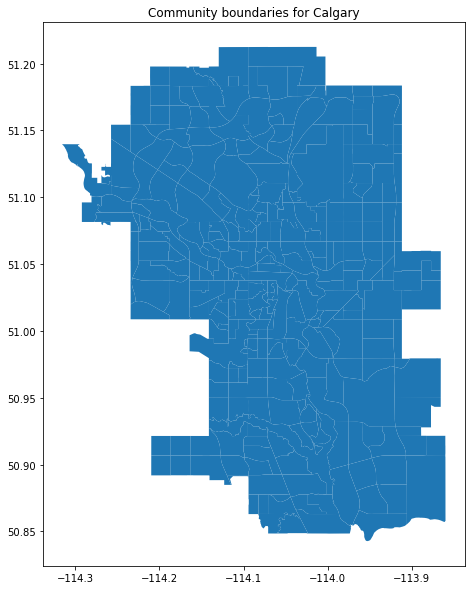

In [8]:
# Source: https://data.calgary.ca/Base-Maps/Community-Boundaries/ab7m-fwn6
boundaries = gpd.read_file('./calgary-communities/boundaries.shp')

# Change to WSG84 standard
boundaries['geometry'] = boundaries['geometry'].to_crs('EPSG:4326')

# Plots
plt.figure(1, figsize=[8, 10])
ax = plt.subplot(1, 1, 1)
ax.set_title('Community boundaries for Calgary')
boundaries.plot(ax=ax);

In [9]:
# Check cols of df
boundaries.head(5)

,class,class_code,comm_code,comm_struc,name,sector,srg,geometry
0,Residential,1.0,NGM,1950s,NORTH GLENMORE PARK,WEST,BUILT-OUT,"POLYGON ((-114.11191 51.00871, -114.11145 51.0..."
1,Residential,1.0,TUX,INNER CITY,TUXEDO PARK,CENTRE,BUILT-OUT,"POLYGON ((-114.06667 51.08151, -114.06597 51.0..."
2,Industrial,2.0,HOR,EMPLOYMENT,HORIZON,NORTHEAST,N/A,"POLYGON ((-113.99729 51.09832, -113.99729 51.0..."
3,Residual Sub Area,4.0,05F,UNDEVELOPED,05F,NORTHEAST,N/A,"POLYGON ((-113.91172 51.15434, -113.91172 51.1..."
4,Residential,1.0,NHU,1960s/1970s,NORTH HAVEN UPPER,NORTH,BUILT-OUT,"POLYGON ((-114.08186 51.10231, -114.08185 51.1..."


In [10]:
# Source: https://data.calgary.ca/Government/Assessments-by-Community/p84b-7zbi
assessments = pd.read_csv('./Assessments_by_Community.csv')

# Only take the latest assessments
assessments = assessments.sort_values(by=['Community name', 'date'])\
           .drop_duplicates(subset=['Community name'], keep='last')

assessments.head(10)

,date,Community name,COMM_CODE,Number of taxable accounts,Median assessed value
197,01/01/2017 12:00:00 AM,Abbeydale,ABB,1804,305000
198,01/01/2017 12:00:00 AM,Acadia,ACA,3854,385000
199,01/01/2017 12:00:00 AM,Albert Park/Radisson Heights,ALB,1918,318000
2,01/01/2016 12:00:00 AM,Albert Park/Radisson Hts,ALB,1916,328000
200,01/01/2017 12:00:00 AM,Altadore,ALT,2855,738000
201,01/01/2017 12:00:00 AM,Alyth/Bonnybrook,AYB,3,104000
202,01/01/2017 12:00:00 AM,Applewood Park,APP,1795,362000
203,01/01/2017 12:00:00 AM,Arbour Lake,ARB,4332,449000
204,01/01/2017 12:00:00 AM,Aspen Woods,ASP,3371,798000
205,01/01/2017 12:00:00 AM,Auburn Bay,AUB,5755,463000


In [11]:
# Merge community assessments with boundaries df
boundaries['name'] = boundaries['name'].str.lower()
assessments['Community name'] = assessments['Community name'].str.lower()
boundaries_assessments = (boundaries.merge(assessments, left_on='name', right_on='Community name', how='inner'))

# Drop redundant cols
boundaries_assessments.drop(['Community name', 'class', 'class_code',
                             'comm_code', 'comm_struc', 'sector', 'srg', 'date', 'COMM_CODE'],
                             axis=1, inplace=True)

# Show cols & vals of df
boundaries_assessments.head(5)

,name,geometry,Number of taxable accounts,Median assessed value
0,north glenmore park,"POLYGON ((-114.11191 51.00871, -114.11145 51.0...",890,594000
1,tuxedo park,"POLYGON ((-114.06667 51.08151, -114.06597 51.0...",1940,450000
2,north haven upper,"POLYGON ((-114.08186 51.10231, -114.08185 51.1...",245,472000
3,winston heights/mountview,"POLYGON ((-114.04746 51.08369, -114.04749 51.0...",1443,483000
4,braeside,"POLYGON ((-114.09521 50.96153, -114.09500 50.9...",2536,373000


We'll hold on to these for the EDA section.

### Schools

While some of the features like ```area```, ```broker```, and ```style``` are a bit too ambiguous to determine, we can fill in information regarding schools using the community boundaries we found above. I found https://www.compareschoolrankings.org/ to be the best resource for school performance, giving scores for each school based on some key indicators. I then used **Selenium** to crawl the website and **BeautifulSoup** to access the information. 

The *Calgary Board of Education* (CBE) divides the city into administrative areas for school designation. However, we can use the community boundaries instead and query the coordinates of each school, determining which community they fall under. Once this is done, we can aggregate the scores of schools within each community to create a new feature that indicates a property's preferability due to its surrounding schools.

In [12]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
from geopy.geocoders import Nominatim # latlng decoder

import time
from collections import defaultdict

In [13]:
RANKING_URL = 'https://www.compareschoolrankings.org'

In [14]:
# Specify options constant for clicks
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("window-size=1920,1080")

# Initialize chrome web driver
driver = webdriver.Chrome(executable_path=r'C:/WebDriver/chromedriver.exe', # Replace with spec location,
                          options=chrome_options)

In [15]:
# Navigate to rankings page
driver.get(RANKING_URL)
time.sleep(5)

# Store all hrefs
school_links = set()

# Specify school type
for tab in driver.find_elements_by_css_selector('a.v-tabs__item'):
    # Click tab twice
    driver.execute_script('arguments[0].click()', tab)
    driver.execute_script('arguments[0].click()', tab)
    
    # Enter calgary as search term
    search_box = driver.find_element_by_id('keyword')
    search_box.send_keys('Calgary')
    search_box.send_keys(Keys.RETURN)
    time.sleep(5)

    # Click on list view button
    element = driver.find_elements_by_xpath("//*[contains(text(), 'List view')]")
    element[0].find_element_by_xpath('./../..').click()
    time.sleep(5)

    # Parse HTML for page count
    ranking_pages = 0
    soup = bs(driver.page_source, 'html.parser')
    for li in soup.select('div.layout.school-list-view-pag.justify-center li.number'):
        mp = int(li.get_text())
        ranking_pages = mp if mp > ranking_pages else ranking_pages 

    for ranking_page in range(ranking_pages):
        # Parse HTML
        soup = bs(driver.page_source, 'html.parser')

        # Scroll down to bottom (Don't think need to do this)
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(5)

        # Add links
        for element in soup.select('td.school-name.text-xs-left a[href]'):
            school_links.add(RANKING_URL + element['href'])

        # Click on next page and wait
        element = driver.find_elements_by_xpath("//*[contains(text(), 'NEXT')]")
        driver.execute_script('arguments[0].click()', element[0])
        time.sleep(5)

In [16]:
print('Number of schools :{}'.format(len(school_links)))

Number of schools :268


*Note: The code below is redundant since the city has a dataset containing school coordinates...*

In [17]:
school_dfs = [] # merge at end

# Convert address to latlng coords
locator = Nominatim(user_agent='calgary-real-estate')

# Make a multidict of community_name -> [score1, ...]
community_scores = defaultdict(list)
for community in boundaries_assessments['name']:
    community_scores[community] = []

# Look through every school and grab scores
for school_link in tqdm(school_links):
    driver.get(school_link)
    time.sleep(5)
    soup = bs(driver.page_source, 'html.parser')    
    
    # Get school
    element = soup.select('div.flex.school-name.row.xs12')[0]
    name = element.get_text()
    
    # Get score
    element = soup.select('div[class*="score_color"]')[0]
    score = float(element.get_text().rstrip('\n'))
    
    # Get address
    element = soup.select('div.flex.school-map-address')[0]
    address = element.get_text().strip('place ').rstrip('\n \n')
    
    # Fix for geocoder: Remove '.' from cardinal directions
    # geocoder doesn't like it...
    address = ''.join(address.rsplit('.', 2))
    
    # Convert to latlng coordinates
    # Note that some of these address strings might not return anything
    location = locator.geocode(address)
    try:
        school_pt = Point(location.longitude, location.latitude)

        # Store into dataframe
        school = {'name': name, 'score': [score], 
                  'address': [address], 'lng': [location.longitude], 
                  'lat': [location.latitude], 'point': [school_pt]}
        school_df = pd.DataFrame.from_dict(school)
        school_dfs.append(school_df)

        # Check which polygon inside community and append
        for community in boundaries['name']:
            community_poly = boundaries[boundaries['name']==community]['geometry'].iloc[0]
            # Both use WGS84 CRS
            if school_pt.within(community_poly):
                community_scores[community].append(score)
                break

    except AttributeError:
        pass


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [24:51<00:00,  5.56s/it]


In [18]:
print('Number of schools inside listed communities: {}'
      .format(sum([len(y) for y in 
                  [x for x in community_scores.values()]
                   if len(y) > 0])))

Number of schools inside listed communities: 248


In [19]:
school_df_final = pd.concat(school_dfs, ignore_index=True)
school_df_final.head(5)

,name,score,address,lng,lat,point
0,Glendale,6.8,"2415 Kelwood Drive SW, Calgary",-114.145583,51.032184,POINT (-114.1455826342463 51.0321842)
1,W. O. Mitchell,7.2,"511 Silvergrove Drive NW, Calgary",-114.194250,51.113577,POINT (-114.1942503938192 51.1135772)
2,Douglas Harkness,5.1,"6203 - 24 Avenue NE, Calgary",-113.945791,51.073837,POINT (-113.9457906689218 51.0738374)
3,Holy Name,9.4,"3011 - 35 Street SW, Calgary",-114.139040,51.027750,POINT (-114.1390398652061 51.02774955)
4,Sunnyside,6.0,"211 - 7 Street NW, Calgary",-114.080076,51.056268,POINT (-114.0800762242211 51.0562675)


In [20]:
community_dfs = [] # avg. score of schools

# Take mean of each entry in multidict, as well as frequency of schools
# within the community
for community, scores in community_scores.items():
    avg_score = (sum(scores) / len(scores)) if len(scores) > 0 else 0.0
    community_entry = {'community': [community], 'avg_score': [avg_score], 'num-schools': [len(scores)]}
    community_df = pd.DataFrame.from_dict(community_entry)
    community_dfs.append(community_df)

# Create dataframe for communities
community_df_final = pd.concat(community_dfs, ignore_index=True)
community_df_final.head(10)

,community,avg_score,num-schools
0,north glenmore park,5.40,2
1,tuxedo park,0.00,0
2,north haven upper,0.00,0
3,winston heights/mountview,6.90,1
4,braeside,3.40,1
5,sherwood,7.00,1
6,chinook park,0.00,0
7,university heights,8.10,2
8,bonavista downs,0.00,0
9,bowness,7.02,5


In [21]:
community_df_final.groupby('num-schools').count()

,community,avg_score
num-schools,,
0,59,59
1,70,70
2,43,43
3,13,13
4,8,8
5,3,3
6,1,1


After looking at the scores for each community, it seems that a lot of communities don't have schools in them. Therefore, it might not be a good idea to take the average. Instead, we probably should employ some spatial analysis technique that would account for this shortcoming. Unfortunately, I did not decide to follow up on this given my lack of experience with the subject, and left this as a future topic to explore. Instead, I chose a simpler approach: 
- For each community with no schools in it (i.e., ``num-schools=0``), query the centroid of its polygon as the center of a circle with some predefined radius, and take the mean of all the schools within it as the new average score.

In [22]:
from functools import partial
import pyproj
from shapely import geometry
from shapely.geometry import Point
from shapely.ops import transform

In [23]:
# Modified from: https://gis.stackexchange.com/questions/121256/creating-a-circle-with-radius-in-metres
radius = 1250  # in m
for index, row in boundaries_assessments.iterrows():
    # Look for matching entry in df
    cross_entry = community_df_final.loc[community_df_final['community'] == row['name']]
    # Skip if >= 1 schools
    if cross_entry['num-schools'].item() > 0:
        continue
    geom = row['geometry']
    lon = geom.centroid.x
    lat = geom.centroid.y
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
        lat, lon
    )
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )
    center = Point(float(lon), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    buffer = point_transformed.buffer(radius)
    
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_wgs84, buffer)
    
    cum_score = 0.0
    num_schools = 0
    for _, _row in school_df_final.iterrows():
        point = _row['point']
        if point.within(circle_poly):
            cum_score += _row['score']
            num_schools += 1
    
    # Edit the original entry
    if num_schools > 0:
        community_df_final.loc[community_df_final['community'] == row['name'], 'avg_score'] = cum_score / num_schools
        community_df_final.loc[community_df_final['community'] == row['name'], 'num-schools'] = num_schools

In [24]:
community_df_final.head(10)

,community,avg_score,num-schools
0,north glenmore park,5.400000,2
1,tuxedo park,5.400000,3
2,north haven upper,6.400000,3
3,winston heights/mountview,6.900000,1
4,braeside,3.400000,1
5,sherwood,7.000000,1
6,chinook park,6.985714,7
7,university heights,8.100000,2
8,bonavista downs,7.525000,4
9,bowness,7.020000,5


All that's left now is to merge the dataframes based on community, removing any house not inside a residential community boundary.

In [25]:
df_final['neighborhood'] = df_final['neighborhood'].str.lower()
community_df_final['community'] = community_df_final['community'].str.lower()

# Merge with community school scores based on community
df_final = (df_final.merge(community_df_final, left_on='neighborhood', right_on='community', how='inner')
 .drop('community', axis=1))

# Merge with community assessments
df_final = (df_final.merge(boundaries_assessments, left_on='neighborhood', right_on='name', how='inner')
 .drop(['name', 'geometry'], axis=1))

Let's also add the additional fees of each property, such as amenities, HOA fees, and condo fees.

In [26]:
# Adding additional fees as a numerical feature
from ast import literal_eval

# Additional fees are 0 if none found
additional_fees = []
for i, row1 in df_final.iterrows():
    additional_fee = 0.0
    costs_df = pd.DataFrame.from_records(literal_eval(row1['extraInfo']))
    if costs_df.empty:
        additional_fees.append(additional_fee)
        continue
    for _, row2 in costs_df.iterrows():
        additional_fee += float(row2['value'].strip('$'))
    additional_fees.append(additional_fee)

# Add column in the end
df_final = df_final.assign(additional_fees=additional_fees)

# Exploratory Data Analysis

In this section, we perform an initial investigation on the dataset before diving into prediction. In particular, we want to:
- Check if our assumptions hold
- Extract key insight from geospatial plots
- Find out any patterns in the data
- Identify the most important features
- Prepare data for regression

## Data Assumptions

Before we can start visualizing our data, we need to make sure our data abides to certain assumptions; our models and plots may not work as expected if they break these. Let's start by producing some summary statistics.

In [27]:
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer
import pylab

In [28]:
# Summary statistics from Pandas
df_final.describe()

,id,area,price,bedrooms,bathrooms,half_bathrooms,square,lot_square,broker,year,...,hoa_dues,district,elementary,middle,high,avg_score,num-schools,Number of taxable accounts,Median assessed value,additional_fees
count,4.184100e+04,0.0,4.184100e+04,41800.000000,41827.000000,25776.000000,41834.000000,3.242800e+04,0.0,41833.000000,...,41841.0,0.0,0.0,0.0,0.0,41841.000000,41841.000000,41841.000000,4.184100e+04,41841.000000
mean,4.644941e+07,NaN,4.640300e+05,3.262368,2.802831,1.043063,1477.162985,1.186606e+06,NaN,1992.922191,...,0.0,NaN,NaN,NaN,NaN,6.207945,1.731961,3977.956167,4.503594e+05,181.673246
std,1.594053e+06,NaN,2.640034e+05,1.111024,1.006897,0.228876,610.064668,6.270742e+07,NaN,21.107328,...,0.0,NaN,NaN,NaN,NaN,2.290768,1.350952,2847.300737,1.281033e+05,232.402138
min,4.541422e+07,NaN,5.400000e+04,1.000000,1.000000,1.000000,103.100000,4.356000e+02,NaN,1071.000000,...,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,108.000000,4.200000e+04,0.000000
25%,4.545476e+07,NaN,3.132000e+05,3.000000,2.000000,1.000000,1042.000000,3.484800e+03,NaN,1979.000000,...,0.0,NaN,NaN,NaN,NaN,6.000000,1.000000,2278.000000,3.730000e+05,0.000000
50%,4.549722e+07,NaN,4.150000e+05,3.000000,3.000000,1.000000,1325.000000,4.791600e+03,NaN,1999.000000,...,0.0,NaN,NaN,NaN,NaN,6.700000,1.000000,3322.000000,4.350000e+05,0.000000
75%,4.717790e+07,NaN,5.450000e+05,4.000000,4.000000,1.000000,1846.000000,6.098400e+03,NaN,2008.000000,...,0.0,NaN,NaN,NaN,NaN,7.500000,2.000000,5122.000000,4.950000e+05,329.000000
max,5.049726e+07,NaN,6.000000e+06,12.000000,19.000000,14.000000,11065.390000,6.851833e+09,NaN,2021.000000,...,0.0,NaN,NaN,NaN,NaN,9.600000,7.000000,17776.000000,1.540000e+06,4058.000000


### Assessed Values Distribution

We can plot the distributions of our data to see if they follow a normal distribution. We can use **seaborn** to plot the distribution of our samples. We also plot both the Q-Q and P-P plots, as well as compute their *kurtosis* (measure of the relative weight of the tails to the center) and *skew* (measure of asymmetry). Altogether, these should give us a sense of whether our data follows a normal distribution.

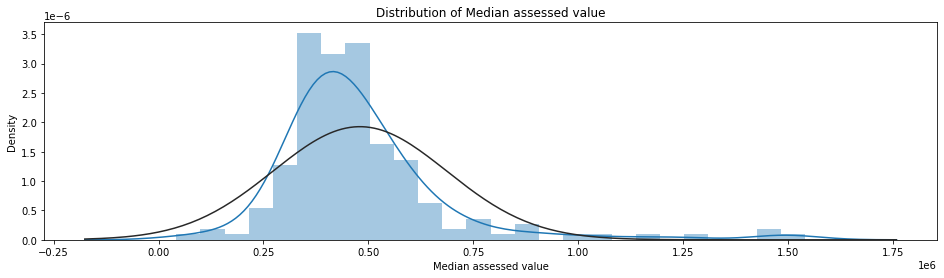

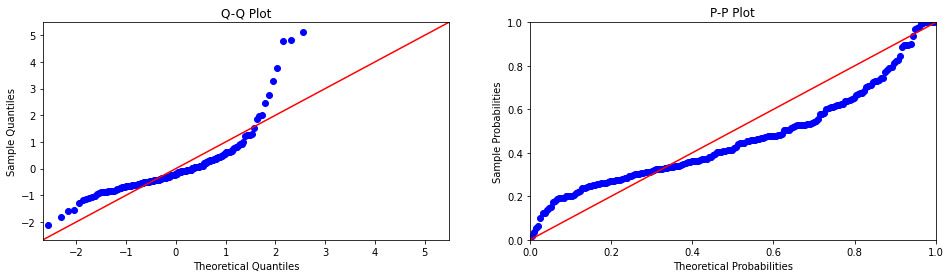

Kurtosis: 8.914 Skew: 2.466


In [29]:
y = boundaries_assessments['Median assessed value']

# Plot histogram for median assessed values
plt.figure(1, figsize=[16, 4])
sns.distplot(y, fit=stats.norm);
plt.title('Distribution of Median assessed value')
plt.show()

# Q-Q plot to check normality assumption
plt.figure(2, figsize=[16, 4])
ax1 = plt.subplot(1,2,1)
pplot = sm.ProbPlot(y, dist=stats.norm, fit=True)
qq = pplot.qqplot(line='45', ax=ax1);
plt.title('Q-Q Plot')
ax2 = plt.subplot(1,2,2)
pp = pplot.ppplot(line='45', ax=ax2);
plt.title('P-P Plot')
plt.show()

# Skew and kurtosis 
kurtosis = round((stats.kurtosis(y)), ndigits=3)
skew = round((stats.skew(y)), ndigits=3)
print('Kurtosis: {} Skew: {}'.format(kurtosis, skew))

Looks like the assessed values don't follow a normal distribution, with a large amount of variation within the tails. This means that using a color gradient to visualize the median assessed values might not bode well for certain communities. For this case, we can use some type of power transformation to stabilize the variance.

We can try using a *Box-Cox Transformation*: A family of transforms parameterized by $\lambda$. In essence, every $\lambda$ value we try corresponds to some kind of transformation (e.g., $\frac{-1}{2}$ is inverse square, $0$ is a natural log transformation etc.). These transformations should affect the tail-ends of the distribution more than the center.

Best lambda: 0.20321764935740746


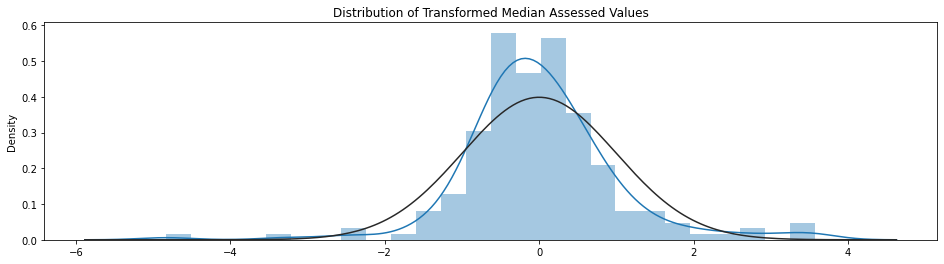

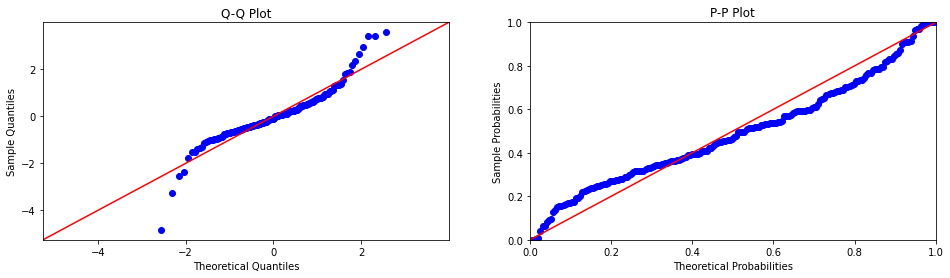

Kurtosis: 4.647 Skew: 0.134


In [30]:
# Find the optimal Box-Cox transform parameter
pt_bc = PowerTransformer(method='box-cox')
y_transformed = pt_bc.fit_transform(y.values.reshape(-1, 1)).squeeze()
bc_lambda = pt_bc.lambdas_[0]
print('Best lambda: {}'.format(bc_lambda))

# Same plots from above for transformed data
plt.figure(1, figsize=[16, 4])
sns.distplot(y_transformed, fit=stats.norm);
plt.title('Distribution of Transformed Median Assessed Values')

# Q-Q plot to check normality assumption
plt.figure(2, figsize=[16, 4])
ax1 = plt.subplot(1,2,1)
pplot = sm.ProbPlot(y_transformed, dist=stats.norm, fit=True)
qq = pplot.qqplot(line='45', ax=ax1);
plt.title('Q-Q Plot')
ax2 = plt.subplot(1,2,2)
pp = pplot.ppplot(line='45', ax=ax2);
plt.title('P-P Plot')
plt.show()

# Skew and Kurtosis 
kurtosis = round((stats.kurtosis(y_transformed)), ndigits=3)
skew = round((stats.skew(y_transformed)), ndigits=3)
print('Kurtosis: {} Skew: {}'.format(kurtosis, skew))

# Add transformed data to df
boundaries_assessments['values_transformed'] = y_transformed

The above plots show that the transformed data still has quite a bit of variability at the tail ends, however it's way better than what we had before.

### Price (Target) Distribution

We can do the same thing for the housing prices, plotting the distribution and corresponding probability plots.

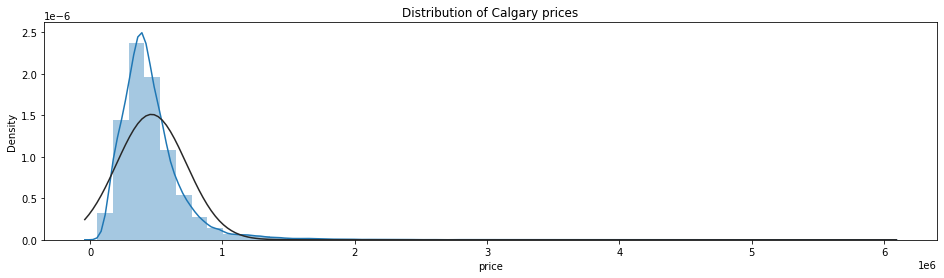

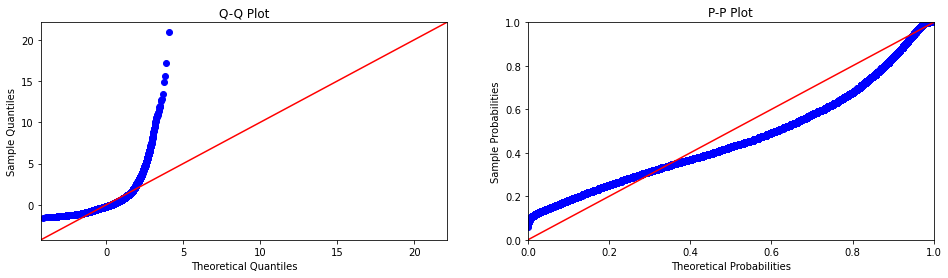

Kurtosis: 30.246 Skew: 3.696


In [31]:
y = df_final['price']

# Plot histogram for median assessed values
plt.figure(1, figsize=[16, 4])
sns.distplot(y, fit=stats.norm);
plt.title('Distribution of Calgary prices')
plt.show()

# Q-Q plot to check normality assumption
plt.figure(2, figsize=[16, 4])
ax1 = plt.subplot(1,2,1)
pplot = sm.ProbPlot(y, dist=stats.norm, fit=True)
qq = pplot.qqplot(line='45', ax=ax1);
plt.title('Q-Q Plot')
ax2 = plt.subplot(1,2,2)
pp = pplot.ppplot(line='45', ax=ax2);
plt.title('P-P Plot')
plt.show()

# Skew and Kurtosis 
kurtosis = round((stats.kurtosis(y)), ndigits=3)
skew = round((stats.skew(y)), ndigits=3)
print('Kurtosis: {} Skew: {}'.format(kurtosis, skew))

Best lambda: -0.07724499095776725


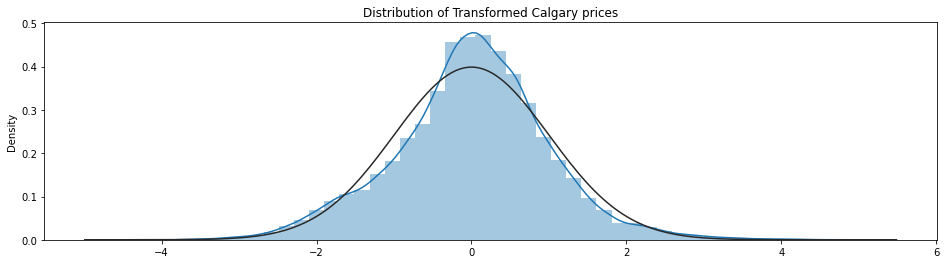

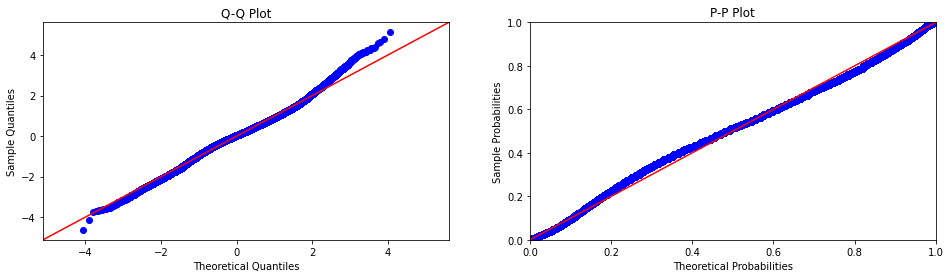

Kurtosis: 0.782 Skew: -0.01


In [32]:
# Find the optimal Box-Cox transform parameter
pt_bc = PowerTransformer(method='box-cox')
y_transformed = pt_bc.fit_transform(y.values.reshape(-1, 1)).squeeze()
bc_lambda = pt_bc.lambdas_[0]
print('Best lambda: {}'.format(bc_lambda))

# Same plots from above for transformed data
plt.figure(1, figsize=[16, 4])
sns.distplot(y_transformed, fit=stats.norm);
plt.title('Distribution of Transformed Calgary prices')

# Q-Q plot to check normality assumption
plt.figure(2, figsize=[16, 4])
ax1 = plt.subplot(1,2,1)
pplot = sm.ProbPlot(y_transformed, dist=stats.norm, fit=True)
qq = pplot.qqplot(line='45', ax=ax1);
plt.title('Q-Q Plot')
ax2 = plt.subplot(1,2,2)
pp = pplot.ppplot(line='45', ax=ax2);
plt.title('P-P Plot')
plt.show()

# Skew and Kurtosis 
kurtosis = round((stats.kurtosis(y_transformed)), ndigits=3)
skew = round((stats.skew(y_transformed)), ndigits=3)
print('Kurtosis: {} Skew: {}'.format(kurtosis, skew))

# Add transformed data to df
df_final['price_transformed'] = y_transformed

## Map Visualization

Now, we can visualize the communities and their corresponding assessed values and house prices using a geospatial visualization tool. Ultimately, I decided to use *Uber's* **KeplerGL** library to visualize these data points, mostly due to its pleasing aesthetics compared to the more simpler alternatives. Granted, this required a tad bit more setup, but the ability to perform aggregations on-the-fly and customize layers without writing code piqued my interests.

In [34]:
from keplergl import KeplerGl

In [35]:
# Initialize the map
_map = KeplerGl(height=800)

# Add community information
_map.add_data(boundaries_assessments, name='Communities')

# Add bare minimum of school information, can't seem to
# load school df
schools_info = {'name': school_df_final['name'],
             'score': school_df_final['score'],
             'lat': school_df_final['lat'], 
             'lng': school_df_final['lng']}
schools_info_df = pd.DataFrame(schools_info)
_map.add_data(schools_info_df, name='Schools')

# Add real estate information
_map.add_data(df_final, name='Real Estate')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [41]:
# Save dfs for embedding html in iframe
df_final.to_csv('./map_df_final.csv', encoding='utf-8')
schools_info_df.to_csv('./map_schools_info_df.csv', encoding='utf-8')
boundaries_assessments.to_csv('./map_boundaries_assessments.csv', encoding='utf-8')

In [33]:
display(_map, height=800)

KeplerGl(data={'Communities': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

In [34]:
config = _map.config
_map.save_to_html(config=config, file_name='calgary-real-estate.html')

Map saved to calgary-real-estate.html!


In [1]:
# from IPython.display import IFrame
# IFrame(src='https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/9f4q1qvv3j7qq78/keplergl_f2wn5wg.json', width=900, height=900)

![Map visualization using KeplerGL](map_keplergl.png)

You can check out the interactive map [here](https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/9f4q1qvv3j7qq78/keplergl_f2wn5wg.json).

We can note the following from the above plot:
- The median assessed values are largely correlated with the house prices, where the darker regions of land corresponding to higher assessed values showcase a large number of red points denoting a high price.
- School scores and number of schools in an area don't necessarily correlate with the price of a house; we see that the closer we get to the city centre, the more properties we have and thus, the need for more schools.
- A large number of the communities on the edge of Calgary are cheaper in price relative to the houses closer to the city.

## Data Preprocessing

In order to perform regression on the data and predict housing prices, we need to ensure that the inputs we give to our models are encoded properly. This means ensuring that all features in the dataset are filled, encoded, and scaled appropriately. In particular, we will be performing the following:
- **Feature Encoding**: Are our features assigned to the correct data types?
- **Feature Imputation**: Are we missing data and if so, how do we fill these in?
- **Feature Engineering**: Can we transform data into a more significant representation?
- **Feature Selection**: Which subset of features are most valuable to our model?

Let's look at our housing data types again.

In [35]:
housing_data = df_final.copy()

In [36]:
# Showing types
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41841 entries, 0 to 41840
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          41841 non-null  int64  
 1   listed_at                   41841 non-null  object 
 2   mls                         41841 non-null  object 
 3   street                      41841 non-null  object 
 4   address                     41841 non-null  object 
 5   city                        41841 non-null  object 
 6   state                       41841 non-null  object 
 7   zip                         41841 non-null  object 
 8   neighborhood                41841 non-null  object 
 9   area                        0 non-null      float64
 10  county                      41841 non-null  object 
 11  price                       41841 non-null  float64
 12  type                        41841 non-null  object 
 13  description                 418

From the above, we can note the following:
- We have a lot of features, and using all of them in our prediction may lead to overfitting. We might have to remove a few.
- Some features shouldn't be kept at prediction time, e.g., ```id```, ```mls```, etc.
- Some features that we want to use as predictors are either missing, in the wrong format, or need to be combined with other features in the dataset in order to be significant.

### Feature Encoding

Let's first start by converting the features we have into something that our models can use. We can perform encoding on the following:
- Community features, e.g., HOA, corner lots, etc.
- Property features: e.g., fencing, pools, etc.
- Interior features: e.g., carpeting, heating, etc.
- House types/styles, e.g., bungalow, apartment, etc.

We can use label encoding for some of these features, where a value of 1 indicates the presence of the feature, and 0 otherwise. For features like house styles, we can use one-hot encoding.

#### Community, Property, and Interior Features

In [37]:
from ast import literal_eval

# Housing features (None = Unknown)
fy_col = []
cfl_col = []
hg_col = []
sb_col = []
hwf_col = []
ga_col = []
p_col = []
pbg_col = []

for i, row in housing_data.iterrows():
    # Replace row with new information
    feature_df = pd.DataFrame.from_records(literal_eval(row['features']))
    for field in feature_df['fields']:
        # 0 is no, 1 is yes, None means not set
        field_dict = {'fy': 0,
                      'cfl': 0,
                      'hg': 0,
                      'sb': 0,
                      'culds': 0,
                      'hwf': 0,
                      'ga': 0,
                      'he': 0,
                      'p': 0, # Combine with pbg
                      'pbg': 0}
        
        for item in field:
            field_dict[item['param']] = 1

    fy_col.append(field_dict['fy'])
    cfl_col.append(field_dict['cfl'])
    hg_col.append(field_dict['hg'])
    sb_col.append(field_dict['sb'])
    hwf_col.append(field_dict['hwf'])
    ga_col.append(field_dict['ga'])
    p_col.append(field_dict['p'])
    pbg_col.append(field_dict['pbg'])

In [38]:
# # Columns added
housing_data['fence'] = fy_col
housing_data['carpet'] = cfl_col
housing_data['gas_heat'] = hg_col
housing_data['storage'] = sb_col
housing_data['wood-floor'] = hwf_col
housing_data['garage-attached'] = ga_col
housing_data['pool'] = p_col
housing_data['pool-bg'] = pbg_col

# Convert to categoricals
housing_data['fence'] = housing_data['fence'].astype('category')
housing_data['carpet'] = housing_data['carpet'].astype('category')
housing_data['gas_heat'] = housing_data['gas_heat'].astype('category')
housing_data['storage'] = housing_data['storage'].astype('category')
housing_data['wood-floor'] = housing_data['wood-floor'].astype('category')
housing_data['garage-attached'] = housing_data['garage-attached'].astype('category')
housing_data['pool'] = housing_data['pool'].astype('category')
housing_data['pool-bg'] = housing_data['pool-bg'].astype('category')

#### House Types

In [39]:
_styles = defaultdict(int)
for i, row in housing_data.iterrows():
    # Replace row with new information
    feature_df = pd.DataFrame.from_records(literal_eval(row['features']))
    res_df = feature_df.loc[feature_df['title'].str.contains('Style')]
    # If style annotated, add to set
    if len(res_df) > 0:
        for j in res_df['fields']:
            for k in j:
                _styles[str(k)] += 1

In [40]:
accounted = 0
for name, count in _styles.items():
    accounted += count
print('Not accounted: {}'.format(len(df_final) - accounted))

Not accounted: 32608


Looks like we have a lot of houses that don't have a house type specified. This means that we could either drop the types completely and just infer from the remaining features, or we can workaround this by imputing the data. One way of doing imputation is to label the house type for a subset of the data by hand, and then impute based on the remaining features. This is known as *model imputation*. A specific example of this is to use some type of neural network to perform image classification and determine the types based on the first image (usually the exterior of the property). I chose to just drop the types instead, leaving this as a future work.

### Feature Imputation

In this section, we attempt to perform feature imputation on the missing data:
- ```sqft```
- ```bedrooms```
- ```bathrooms```
- ```year```

We can use *K-Nearest Neighbours* to impute the missing features. 

In [41]:
from sklearn.impute import KNNImputer

In [42]:
# Get predictors and anything else useful for later
needed_features = ['price_transformed', 'bedrooms', 'bathrooms', 'half_bathrooms', 'square', 'year', 'Number of taxable accounts',
                  'Median assessed value',  'additional_fees', 'fence', 'carpet', 'gas_heat', 'storage',
                  'wood-floor', 'garage-attached', 'pool', 'pool-bg', 'avg_score', 'num-schools']
housing_needed = housing_data[needed_features]

In [43]:
# Fill NA values as 0
housing_needed['half_bathrooms'] = housing_needed['half_bathrooms'].fillna(0.0)

In [44]:
# KNN imputer
imputer = KNNImputer(n_neighbors=30, weights='uniform')
housing_needed_filled = pd.DataFrame(imputer.fit_transform(housing_needed), columns=housing_needed.columns)

label_cols = ['fence', 'carpet', 'gas_heat', 'storage',
              'wood-floor', 'garage-attached', 'pool', 'pool-bg']

# Replace floats back to labels
for label_col in label_cols:
    housing_needed_filled[label_col] = housing_needed[label_col]

### Feature Engineering

Examining the remaining features left in the original dataframe, we can leverage the data for listing and sold times to get any given house's time on the market. This feature could potentially be a very good indicator of a house's price.

In [45]:
from ast import literal_eval

market_days = [] # in days
housing_data['listed_at'] = pd.to_datetime(housing_data['listed_at'], utc=True)

for i, row in housing_data.iterrows():
    listed_date = row['listed_at']
    price_df = pd.DataFrame.from_records(literal_eval(row['priceHistory']))
    sold_date = pd.to_datetime(price_df['date'][0], utc=True)
    if sold_date:
        market_days.append((sold_date - listed_date).days)
    else:
        market_days.append(None)

housing_needed_filled['days_on_market'] = market_days

In [46]:
# Change to appropriate types
housing_needed_filled['bedrooms'] = housing_needed_filled['bedrooms'].astype(int)
housing_needed_filled['bathrooms'] = housing_needed_filled['bathrooms'].astype(int)
housing_needed_filled['half_bathrooms'] = housing_needed_filled['half_bathrooms'].astype(int)
housing_needed_filled['year'] = housing_needed_filled['year'].astype(int)

In [47]:
housing_needed_filled.head(5)

,price_transformed,bedrooms,bathrooms,half_bathrooms,square,year,Number of taxable accounts,Median assessed value,additional_fees,fence,carpet,gas_heat,storage,wood-floor,garage-attached,pool,pool-bg,avg_score,num-schools,days_on_market
0,-0.393897,4,3,2,1173.0,1974,3160.0,322000.0,0.0,0,1,1,0,0,0,0,0,5.55,4.0,1
1,-1.974654,2,1,0,924.4,1975,3160.0,322000.0,275.0,0,1,1,0,0,0,0,0,5.55,4.0,20
2,-3.099463,1,1,0,429.0,2001,3160.0,322000.0,329.0,0,1,0,0,0,0,0,0,5.55,4.0,110
3,-1.566576,3,2,1,1167.0,1976,3160.0,322000.0,271.0,0,1,1,0,0,0,0,0,5.55,4.0,27
4,-0.737087,3,2,1,1143.0,1976,3160.0,322000.0,0.0,0,1,1,0,0,0,0,0,5.55,4.0,23


### Feature Selection

In this section, we look at reducing the number of features to potentially lessen overfitting, training time, and make our model more generalizable in the test setting.

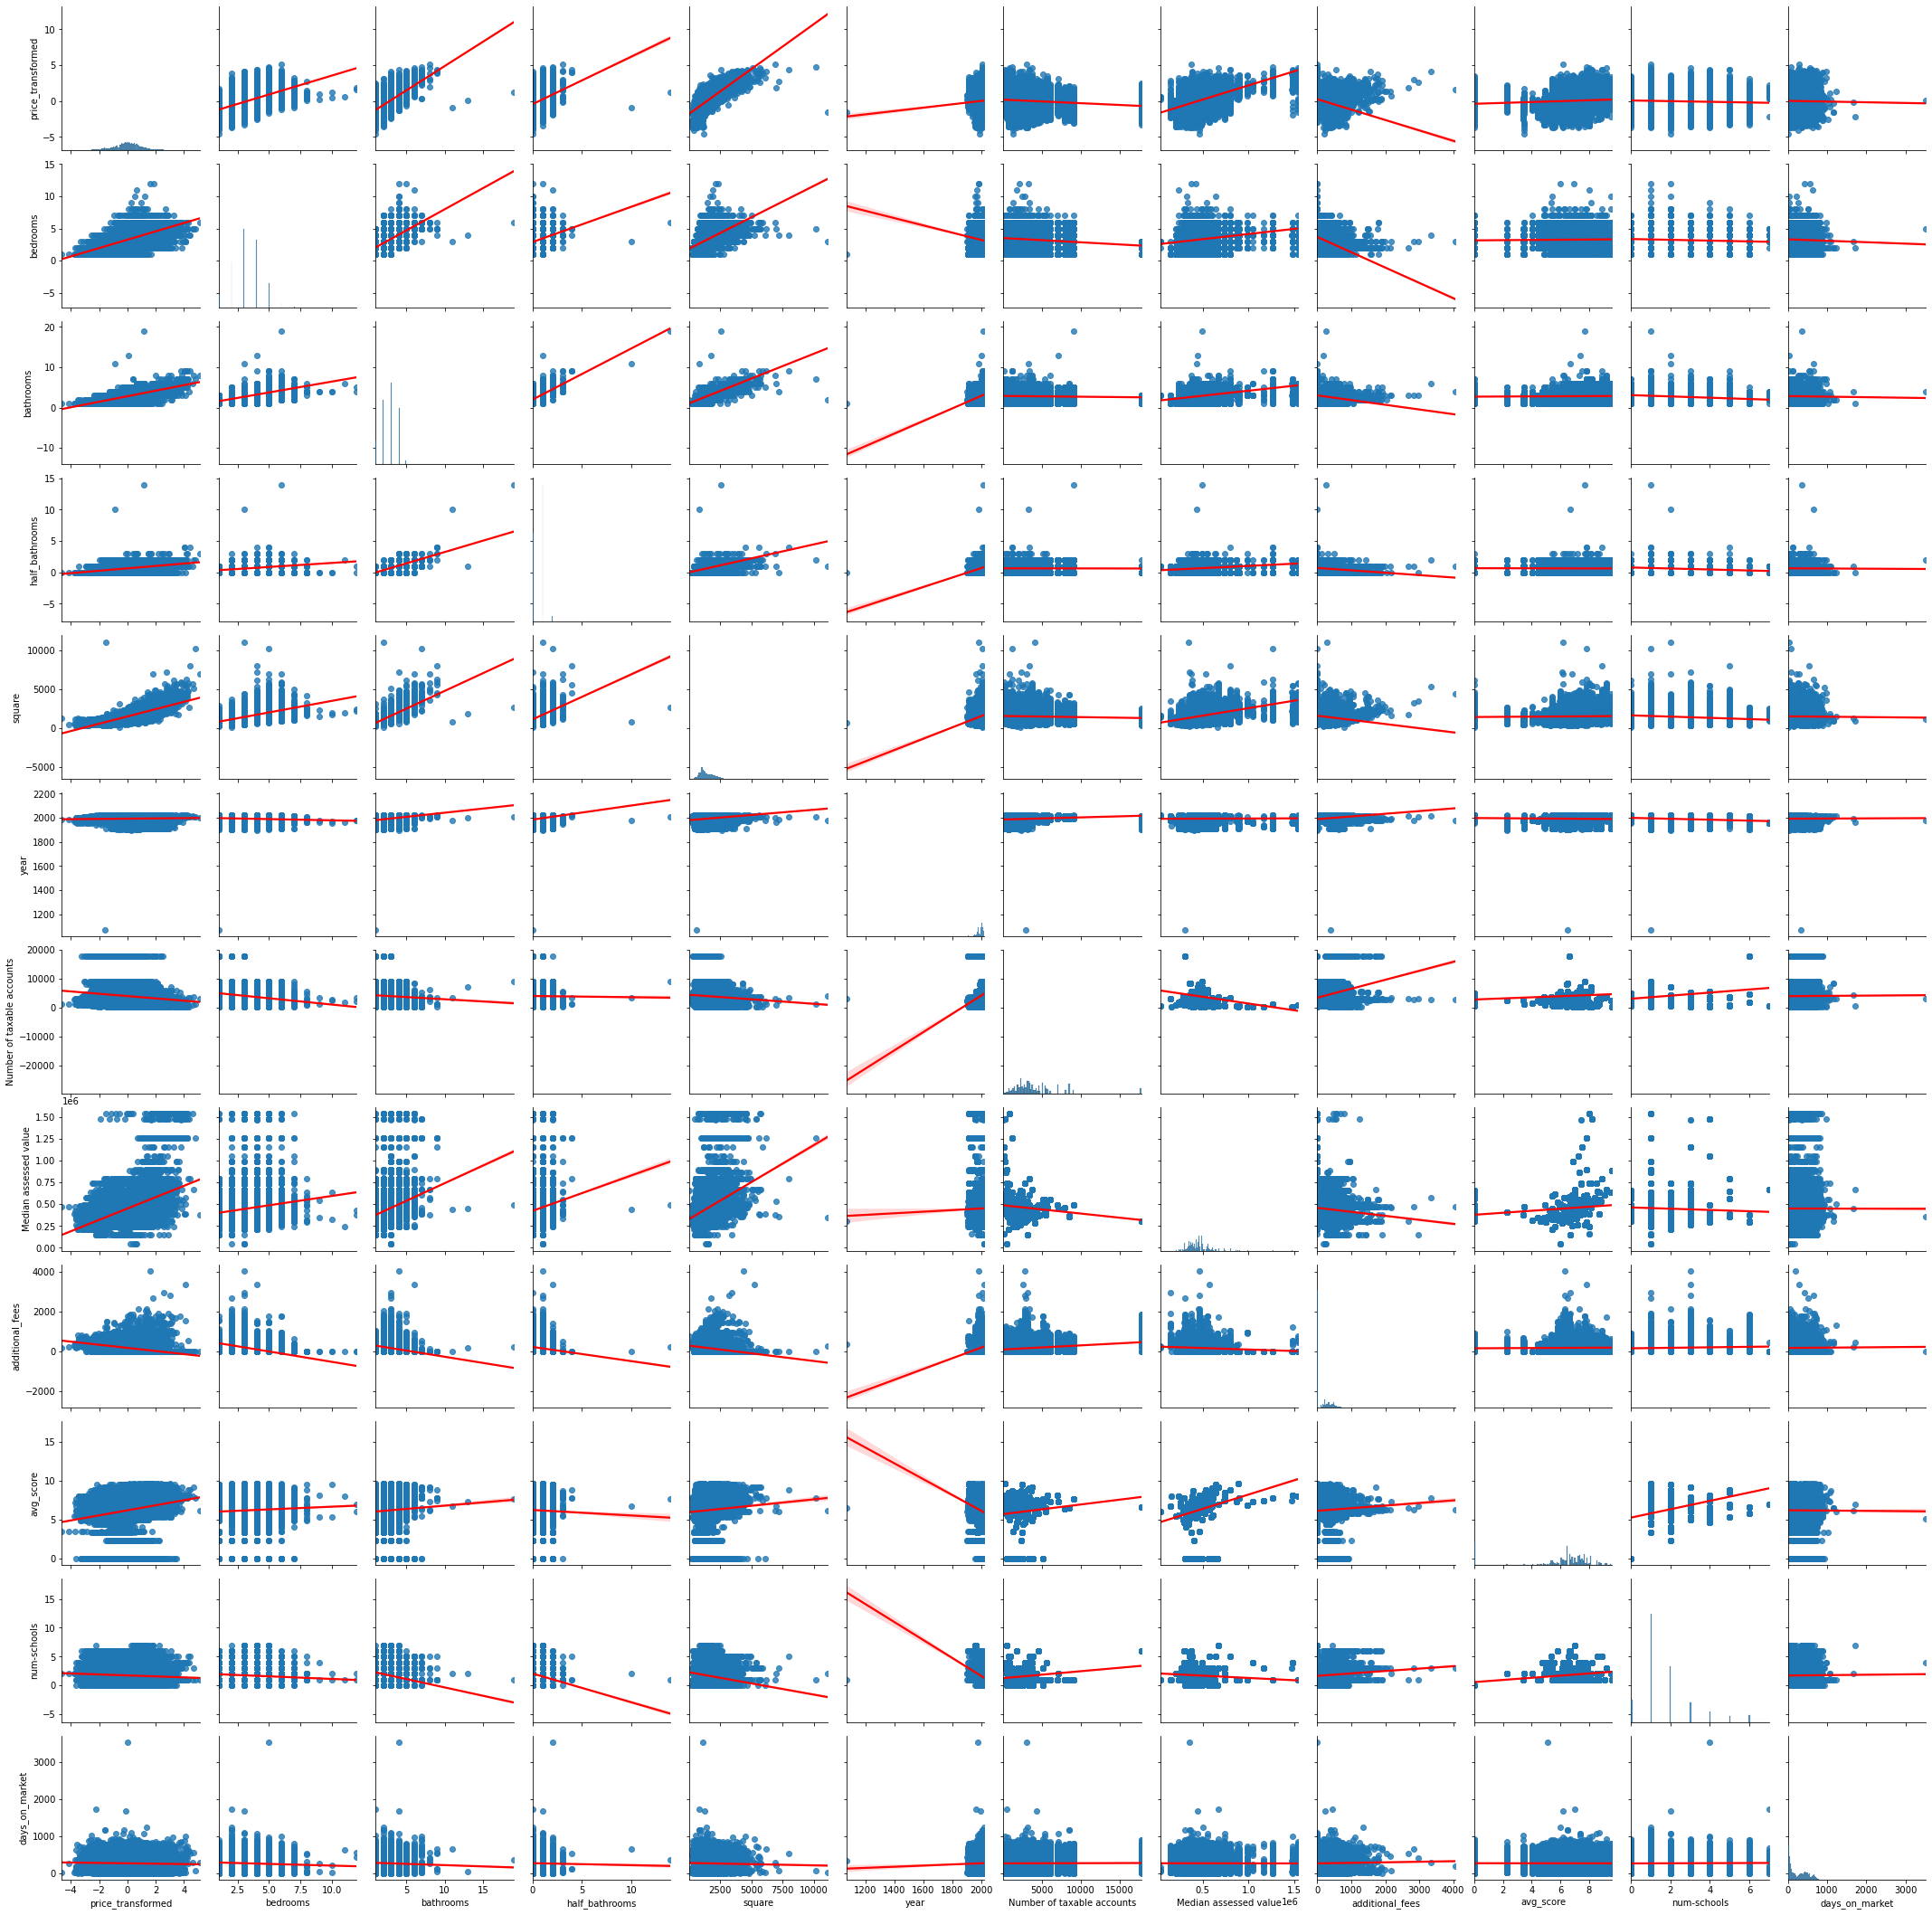

In [50]:
# Plot pairs for numerical features and create line fit using regression
grid = sns.PairGrid(housing_needed_filled)
grid.map_diag(sns.histplot)
grid.map_offdiag(sns.regplot, line_kws={'color': 'red'})
plt.show()

From the above, it looks as though there exists a postive correlation between a given house's square footage and price, which makes sense. For the other features such as number of bedrooms and bathrooms, as well as median assessed values, there seems to be a positive correlation as well.

Let's also plot all the categorical features against price feature.

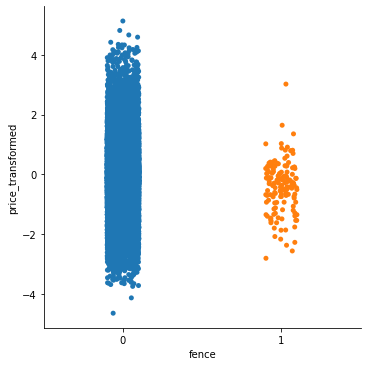

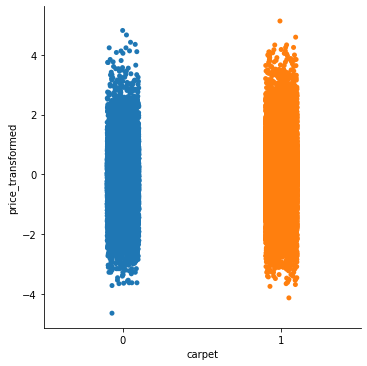

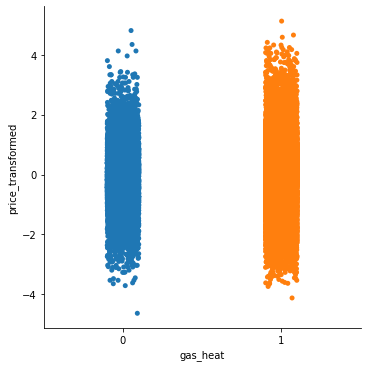

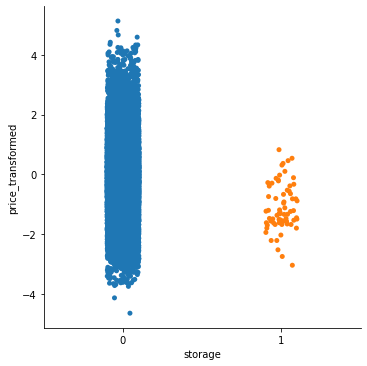

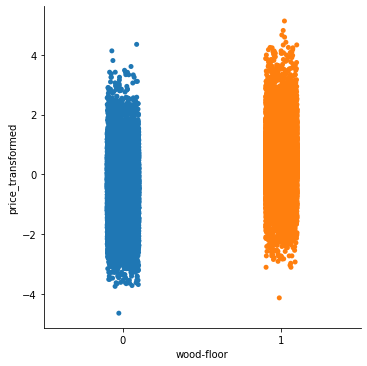

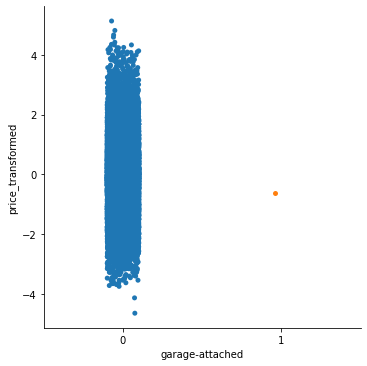

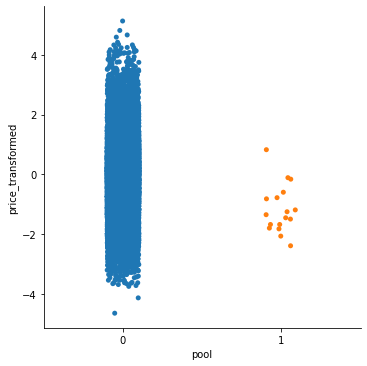

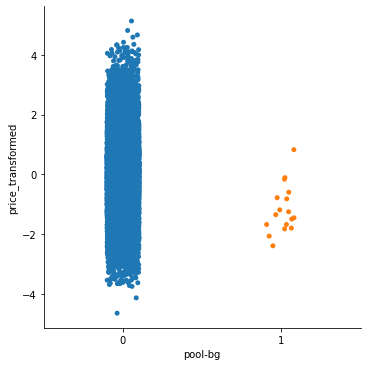

In [52]:
for col in housing_needed_filled.select_dtypes(include=['category']).columns:
    catplot = sns.catplot(x=col, y='price_transformed', data=housing_needed_filled);

There seems to be a few class imbalances in the data, which can be attributed to false reporting since the AlbertaRE website I retrieved the data from has a lot of missing information. We can thus remove these when we perform regression.

In [48]:
imbalanced_cols = ['fence', 'storage', 'garage-attached', 'pool', 'pool-bg']
housing_needed_filled.drop(imbalanced_cols, axis=1, inplace=True)

Finally, let's plot a correlation matrix to see which features correlate the most with the price target feature.

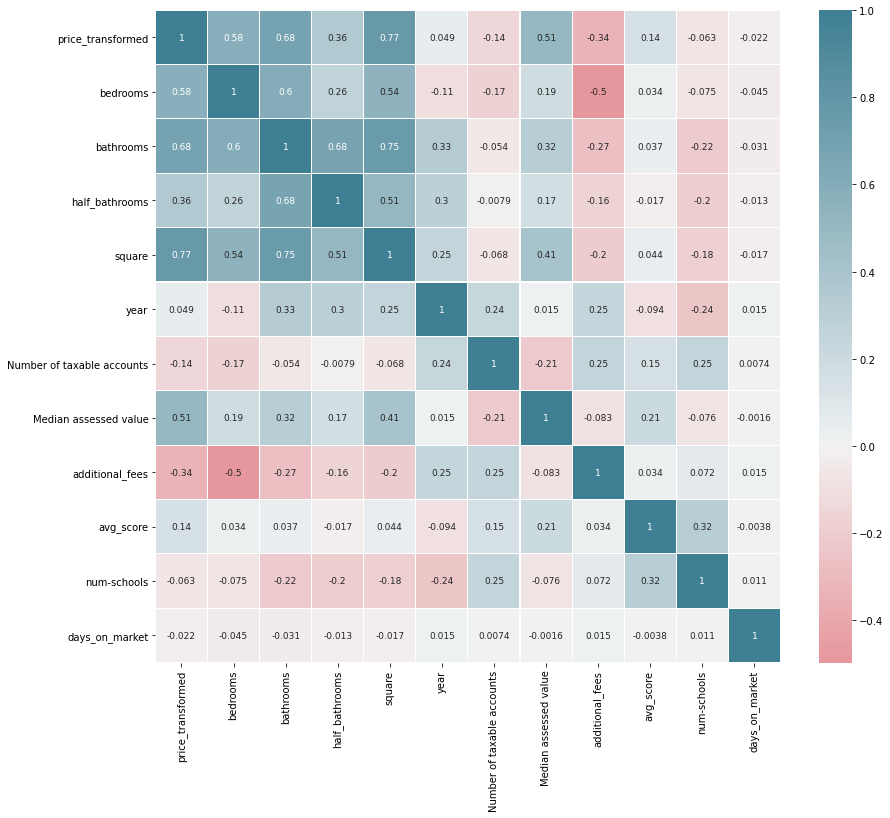

In [54]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize = [14,12])
colormap = sns.diverging_palette(10, 220, as_cmap=True)
fig = sns.heatmap(housing_needed_filled.corr(),
            cmap=colormap,
            center=0,
            annot=True,
            linewidths=0.1,
            annot_kws={'fontsize':9})

From the above, we note that the number of bedrooms and bathrooms, and median assessed values are highly correlated with the transformed price. On the other end, we see that the additional housing fees are negatively correlated with the transformed price.

### Feature Transformation

Finally, we want to apply *Box-Cox* on our numerical features to meet certain assumptions when it comes time to prediction. However, we can only apply this method to positive data. To fix this, we instead use the *Yeo-Johnson* power transformations. Here, we'll use **sklearn**'s power transformation module.

In [49]:
from sklearn.preprocessing import PowerTransformer

# Make copy for final edited
housing_transformed = housing_needed_filled.copy()

# Grab all numerical features to perform power transformation on
numerical_features = []
categorical_features = housing_transformed.select_dtypes(include=['category']).columns
for col in housing_transformed.columns:
    if col not in categorical_features:
        numerical_features.append(col)

numerical_features.remove('price_transformed')

# Power transformation and keep track of lambdas
yj_lambdas = []
pt = PowerTransformer(method='yeo-johnson')

for feature in numerical_features:
    housing_transformed[feature] = pt.fit_transform(X=housing_transformed[[feature]], y=housing_transformed[['price_transformed']])
    yj_lambdas.append(pt.lambdas_[0])

In [50]:
to_dummies_cols = ['carpet', 'gas_heat', 'wood-floor']
housing_transformed = pd.get_dummies(housing_transformed, columns=to_dummies_cols)

Let's take one final look at the data, then we can proceed to performing prediction.

In [51]:
housing_transformed.head(5)

,price_transformed,bedrooms,bathrooms,half_bathrooms,square,year,Number of taxable accounts,Median assessed value,additional_fees,avg_score,num-schools,days_on_market,carpet_0,carpet_1,gas_heat_0,gas_heat_1,wood-floor_0,wood-floor_1
0,-0.393897,0.677490,0.217726,2.283731,-0.381563,-1.065639,-0.080629,-1.266443,-0.974374,-0.62554,1.528765,-2.024609,0,1,0,1,1,0
1,-1.974654,-1.140262,-1.850232,-1.219257,-0.971861,-1.029093,-0.080629,-1.266443,0.966040,-0.62554,1.528765,-1.322205,0,1,0,1,1,0
2,-3.099463,-2.139813,-1.850232,-1.219257,-2.846753,0.257023,-0.080629,-1.266443,1.020611,-0.62554,1.528765,-0.385987,0,1,1,0,1,0
3,-1.566576,-0.207899,-0.785668,0.691945,-0.394316,-0.991749,-0.080629,-1.266443,0.961564,-0.62554,1.528765,-1.193993,0,1,0,1,1,0
4,-0.737087,-0.207899,-0.785668,0.691945,-0.445971,-0.991749,-0.080629,-1.266443,-0.974374,-0.62554,1.528765,-1.264163,0,1,0,1,1,0


# Prediction

Now that we have our data prepared, we can finally start performing regression on our data for predicting the prices of houses in Calgary.

In this section, we can iterate over several regression techniques provided by **SciKit-Learn** to determine which statistical model performs the best. This method was inspired by *Slava Spirin* from his [Medium](https://medium.com/@slavaspirin/toronto-housing-price-prediction-359b4a0aa9a7) post. I'd highly advise checking it out. 

Essentially, we create an estimator space using preselected models, and then perform hyperparameter tuning on the best performing models using **hyperopt**.

## Finding the Best Model

We will be using the following models:
- Linear Regression (OLS): Minimize squared-difference of residuals by optimizing value of coefficients.
- Ridge, LASSO, and Elastic Net Regression: Penalize the OLS model by adding the norms of the coefficients to the objective.
- Least Angle Regression (LARS): Stepwise process that updates coefficients of predictors with highest correlation with residuals.
- Bayesian Regression: Similar to OLS, but estimates probabilistic model.
- XGB: Ensemble method using a gradient boosting framework.
- LBGM: Gradient boosting framework using decision tree algorithms.

In [52]:
from sklearn.model_selection import train_test_split

# Separate predictors and target variables
housing_transformed_copy = housing_transformed.copy()
prices = housing_transformed_copy['price_transformed']
housing_transformed_copy.drop('price_transformed', axis=1, inplace=True)
predictors = housing_transformed_copy.columns

# Split 80/20 training test
X_train, X_test, y_train, y_test = train_test_split(housing_transformed_copy[predictors], 
                                                    prices, train_size=0.8)

In [53]:
from scipy.special import inv_boxcox
from sklearn import base
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, BayesianRidge, ElasticNetCV, LarsCV
from sklearn.svm import NuSVR, SVR
from sklearn.model_selection import ShuffleSplit, cross_validate, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import xgboost as xgb

In [54]:
# Regressor space
regressors = [
    LinearRegression(),
    make_pipeline(RobustScaler(), LassoCV()),
    RidgeCV(),
    make_pipeline(RobustScaler(), ElasticNetCV()),
    LarsCV(),
    BayesianRidge(),
#     SVR(),
#     NuSVR(), # Omit since takes a long time
    lgb.LGBMRegressor(),
    xgb.XGBRegressor()
]

# Using absolute error
def custom_mae_(y, y_pred, **kwargs):
    y = pt_bc.inverse_transform(pd.DataFrame(y))
    y_pred = pt_bc.inverse_transform(pd.DataFrame(y_pred))
    return mean_absolute_error(y, y_pred)
custom_mae = make_scorer(custom_mae_, greater_is_better=False)

# Cross validation training split
cross_validation_split = KFold(n_splits=4, shuffle=True, random_state=123)

# Dataframe for metrics
metric_dfs = []

# Iterate over regressor space, perform training and testing, and report
# results to df
for i, method in enumerate(tqdm(regressors)):
    method_name = method.__class__.__name__
    method_params = str(method.get_params())
    cv_results = cross_validate(method, X_train, y_train, 
                                cv=cross_validation_split,
                                return_train_score=True,
                                scoring=custom_mae)
    row = {'Method': method_name,
           'Parameters': method_params,
           'Mean training accuracy': -cv_results['train_score'].mean(),
           'Mean testing accuracy': -cv_results['test_score'].mean(),
           'Time': cv_results['fit_time'].mean()}
    metric_df = pd.DataFrame.from_dict([row])
    metric_dfs.append(metric_df)
    
metric_df_final = pd.concat(metric_dfs, ignore_index=True)
metric_df_final.sort_values('Mean training accuracy', inplace=True, ascending=True)
metric_df_final

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.29it/s]


,Method,Parameters,Mean training accuracy,Mean testing accuracy,Time
7,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",37477.065477,50468.089497,0.537312
6,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",48524.857931,52465.685340,0.138130
3,Pipeline,"{'memory': None, 'steps': [('robustscaler', Ro...",79542.318824,79602.732115,0.283492
1,Pipeline,"{'memory': None, 'steps': [('robustscaler', Ro...",79558.637142,79618.893512,0.241853
2,RidgeCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'cv': No...",79608.780703,79669.696637,0.027674
5,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...",79609.895883,79670.815004,0.015708
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",79611.529608,79672.498279,0.017702
4,LarsCV,"{'copy_X': True, 'cv': None, 'eps': 2.22044604...",80299.867973,80388.268658,0.103473


From the above, it looks like past the gradient boosting methods, we see little variation in the mean training and test scores. Another thing to note is that the XGBRegressor performed the best during training with a mean score of around 38000, but performed way worse in the test setting. We can also plot the regression methods and their losses to see this.

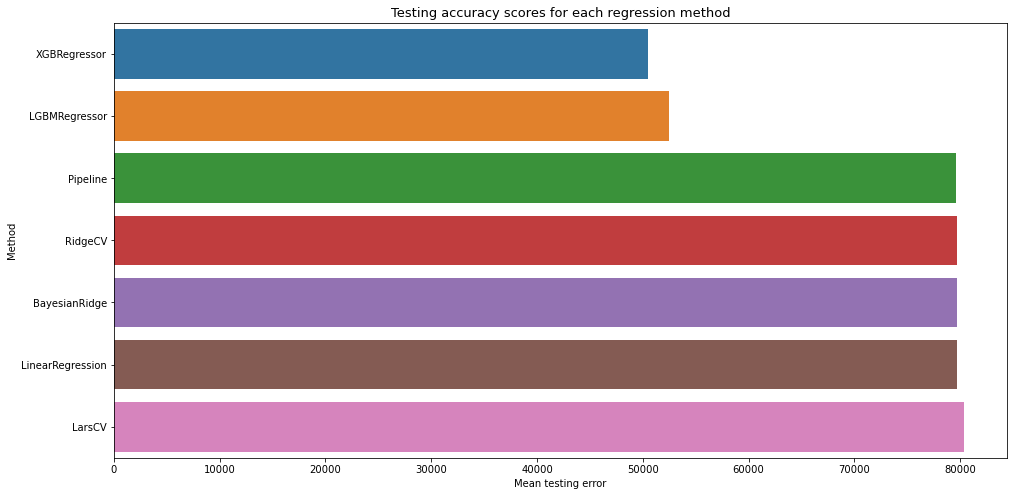

In [55]:
fig, ax = plt.subplots(figsize = [16,8])
sns.barplot(x='Mean testing accuracy', y='Method', data=metric_df_final)
plt.title('Testing accuracy scores for each regression method', fontsize=13)
plt.xlabel('Mean testing error')
plt.ylabel('Method')
plt.show()

## Hyperparameter Tuning

In this section, we attempt to make our best performing models even better using hyperparameter tuning. We choose to perform tuning on the *XBGRegressor* and the *LGBMRegressor*, since they had the lowest validation losses compared to the other models.

### LightGBM with Bayesian Optimization

In [56]:
# Copied and Modified from https://nbviewer.jupyter.org/github/SlavOK400/Toronto-housing-price-prediction/blob/master/GTA_housing.ipynb
import numpy as np
from hyperopt import hp
from hyperopt import Trials, tpe, fmin, STATUS_OK
from timeit import default_timer as timer
from sklearn.utils import check_random_state

# Create dataset for lightgbm
training_set = lgb.Dataset(X_train, label=y_train, free_raw_data=False)

# Hyperparameter grid to specify domain of search
param_grid = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'verbose': -1
}

In [57]:
def custom_mae_lgb(y_pred, y):
    y = pt_bc.inverse_transform(pd.DataFrame(y.get_label()))
    y_pred = pt_bc.inverse_transform(pd.DataFrame(y_pred))
    return 'custom_mae_lgb', mean_absolute_error(y, y_pred), False

# Objective function to calculate score to optimize
def objective(params):
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)

    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample

    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, training_set, num_boost_round=1000, folds=cross_validation_split, 
                        early_stopping_rounds=50, seed=123, stratified=False, feval=custom_mae_lgb)
    
    run_time = timer() - start
    
    # Extract the best score, Loss must be minimized
    best_score = np.min(cv_results['custom_mae_lgb-mean'])
    
    loss = best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['custom_mae_lgb-mean']) + 1)
    
    # Dictionary with information for evaluation
    return {'loss': best_score, 'params': params, 'estimators': n_estimators,
            'train_time': run_time, 'status': STATUS_OK}

In [58]:
# Trials to keep track of process
trials = Trials()

rng = check_random_state(123)

# Hyperopt uses Tree-structured Parzen Estimator (TPE) for surrogate model
lgb_best = fmin(fn=objective, space=param_grid, algo=tpe.suggest,
                max_evals=250, trials=trials, rstate=rng)

# This is a simple helper function that allows us to fill in `np.nan` when a particular
# hyperparameter is not relevant to a particular trial
# Copied from: https://www.statestitle.com/resource/visualizing-hyperparameter-optimization-with-hyperopt-and-plotly/
def unpack(x):
    if x:
        return x[0]
    return np.nan

# We'll first turn each trial into a series and then stack those series together as a dataframe.
# Copied from: https://www.statestitle.com/resource/visualizing-hyperparameter-optimization-with-hyperopt-and-plotly/
trials_df = pd.DataFrame([pd.Series(t['misc']['vals']).apply(unpack) for t in trials])
trials_df['loss'] = [t['result']['loss'] for t in trials]
trials_df['trial_number'] = trials_df.index

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [2:56:32<00:00, 42.37s/trial, best loss: 47105.205170498964]


In [64]:
# Grab top 5 results
trials_df.sort_values(by=['loss']).head(5)

,boosting_type,class_weight,colsample_by_tree,dart_subsample,gdbt_subsample,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,loss,trial_number
19,1.0,0.0,0.674398,0.680132,NaN,0.152934,20.0,137.0,0.772249,0.948146,120000.0,47105.205170,19
147,0.0,0.0,0.714780,NaN,0.665332,0.028581,20.0,123.0,0.887078,0.802187,140000.0,47114.905592,147
148,0.0,0.0,0.700548,NaN,0.657647,0.028988,20.0,124.0,0.888736,0.786208,220000.0,47183.087573,148
153,0.0,0.0,0.748601,NaN,0.513448,0.031981,20.0,105.0,0.918487,0.821162,240000.0,47263.956730,153
157,0.0,0.0,0.677293,NaN,0.632701,0.038712,20.0,113.0,0.882143,0.755818,260000.0,47267.524000,157


We can also plot the loss values against the various hyperparameters to see which hyperparameter values corresponded with lower losses.

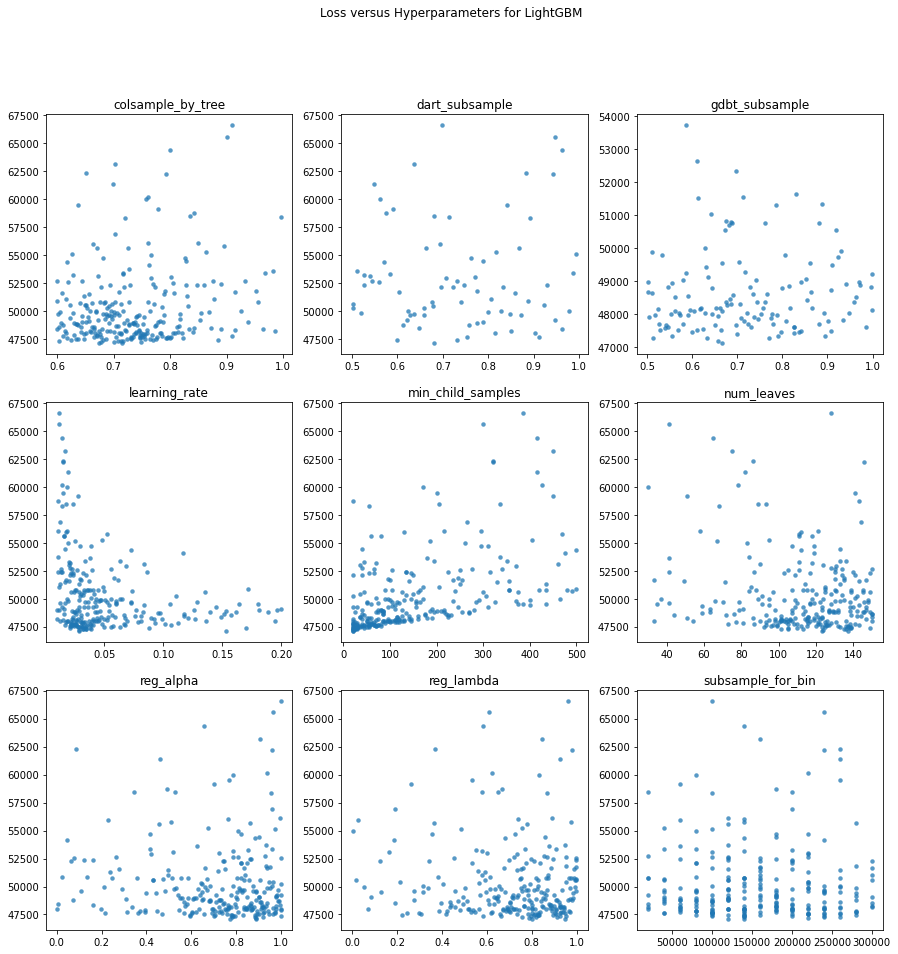

In [60]:
# Modified from: https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt
# Create subplots of all hyperparameter curves
parameters = ['colsample_by_tree', 'dart_subsample', 'gdbt_subsample', 
              'learning_rate', 'min_child_samples', 'num_leaves',
              'reg_alpha', 'reg_lambda', 'subsample_for_bin']    

cols = int(len(parameters) / 3)
f, axes = plt.subplots(nrows=3, ncols=cols, figsize=(15,15))
for i, val in enumerate(parameters):
    crow = int(i / 3)
    ccol = int(i % 3)
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if len(t['misc']['vals'][val]) != 0]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials if len(t['misc']['vals'][val]) != 0]
    new_xs = [x[0] for x in sorted(zip(xs, ys)) if x[0] is not None]
    new_ys = [abs(x[1]) for x in sorted(zip(xs, ys)) if x[0] is not None]
    ys = np.array(new_ys)
    axes[crow, ccol].scatter(new_xs, ys, s=20, linewidth=0.01, alpha=0.75)
    axes[crow, ccol].set_title(val)
    
f.suptitle('Loss versus Hyperparameters for LightGBM')
plt.show()

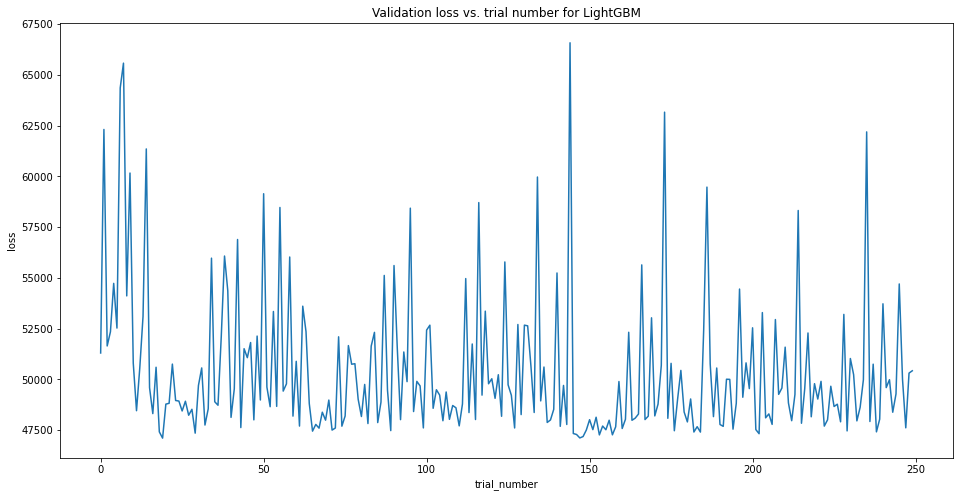

In [61]:
# Graphing loss vs trials
plt.figure(figsize=(16, 8))
sns.lineplot(x="trial_number", y="loss", data=trials_df).set_title("Validation loss vs. trial number for LightGBM");
plt.show()

Let's see how well LightGBM with the best performing hyperparameters work on the test set.

In [63]:
# Sort the trials
lgb_trials_results = sorted(trials.results, key = lambda x: x['loss'])

# Convert to a dataframe
lgb_results = pd.DataFrame(lgb_trials_results)

# Save best parameters
best_lgb_estimators= lgb_results.loc[0,'estimators']
best_lgb_params= lgb_results.loc[0,'params']

# Use hyperparameters on test
best_lgb_model = lgb.LGBMRegressor(n_estimators=best_lgb_estimators, n_jobs=-1, 
                                   random_state=rng, **best_lgb_params)

# Fit model
best_lgb_model.fit(X_train, y_train)

# Save best model
best_lgb_model.booster_.save_model('lgb_model.txt') 

# # Load best model
# best_lgb_model = lgb.Booster(model_file='lgb_model.txt')

# Prediction
y_pred = best_lgb_model.predict(X_test)
print('Mean absolute error on best performing LightGBM Regressor: {}'.format(custom_mae_(y_test, y_pred)))

Mean absolute error on best performing LightGBM Regressor: 46543.62277872029


### XGBoost with Bayesian Optimization

In [69]:
# Copied and Modified from https://nbviewer.jupyter.org/github/SlavOK400/Toronto-housing-price-prediction/blob/master/GTA_housing.ipynb
# Convert to DMat
training_set = xgb.DMatrix(X_train.values, label = y_train.values)

# Define the search space
param_grid = {
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'max_depth': hp.quniform('max_depth', 1, 5, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'gamma': hp.quniform('gamma', 0.5,5,0.5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'verbosity': 0
}

def custom_mae_xgb(y_pred, y):
    y = pt_bc.inverse_transform(pd.DataFrame(y.get_label()))
    y_pred = pt_bc.inverse_transform(pd.DataFrame(y_pred))
    return 'custom_mae_xgb', mean_absolute_error(y, y_pred)

def objective(params):
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'min_child_weight']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = xgb.cv(params, training_set, num_boost_round=500, folds=cross_validation_split, 
                        early_stopping_rounds=50, seed=123, feval=custom_mae_xgb)
    
    run_time = timer() - start
        
    # Extract the best score, Loss must be minimized
    best_score = np.min(cv_results['test-custom_mae_xgb-mean'])
    
    loss = best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['test-custom_mae_xgb-mean']) + 1)
    
    # Dictionary with information for evaluation
    return {'loss': best_score, 'params': params, 'estimators': n_estimators,
            'train_time': run_time, 'status': STATUS_OK}

In [70]:
# Trials to keep track of process
xgb_trials = Trials()

# Hyperopt uses Tree-structured Parzen Estimator (TPE) for surrogate model
xgb_best = fmin(fn=objective, space=param_grid, algo=tpe.suggest,
                max_evals=100, trials=xgb_trials, rstate=rng)

# Sort the trials with lowest loss first
xgb_trials_results = sorted(xgb_trials.results, key = lambda x: x['loss'])

# We'll first turn each trial into a series and then stack those series together as a dataframe.
# Copied from: https://www.statestitle.com/resource/visualizing-hyperparameter-optimization-with-hyperopt-and-plotly/
xgb_trials_df = pd.DataFrame([pd.Series(t['misc']['vals']).apply(unpack) for t in xgb_trials])
xgb_trials_df['loss'] = [t['result']['loss'] for t in xgb_trials]
xgb_trials_df['trial_number'] = xgb_trials_df.index

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:58:13<00:00, 178.93s/trial, best loss: 49779.100586]


In [71]:
# Grab top 5 results
xgb_trials_df.sort_values(by=['loss']).head(5)

,booster,colsample_by_tree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,loss,trial_number
82,0.0,0.860835,0.5,0.127958,5.0,15.0,0.368795,0.037938,0.606271,49779.100586,82
78,0.0,0.917996,0.5,0.096702,5.0,20.0,0.352505,0.055813,0.583422,50040.170898,78
65,2.0,0.954761,0.5,0.076836,5.0,18.0,0.641777,0.965516,0.550667,50148.041015,65
67,2.0,0.966361,0.5,0.063819,5.0,17.0,0.616787,0.961237,0.634067,50271.794922,67
79,0.0,0.842700,0.5,0.184080,5.0,20.0,0.407506,0.160920,0.518630,50326.477539,79


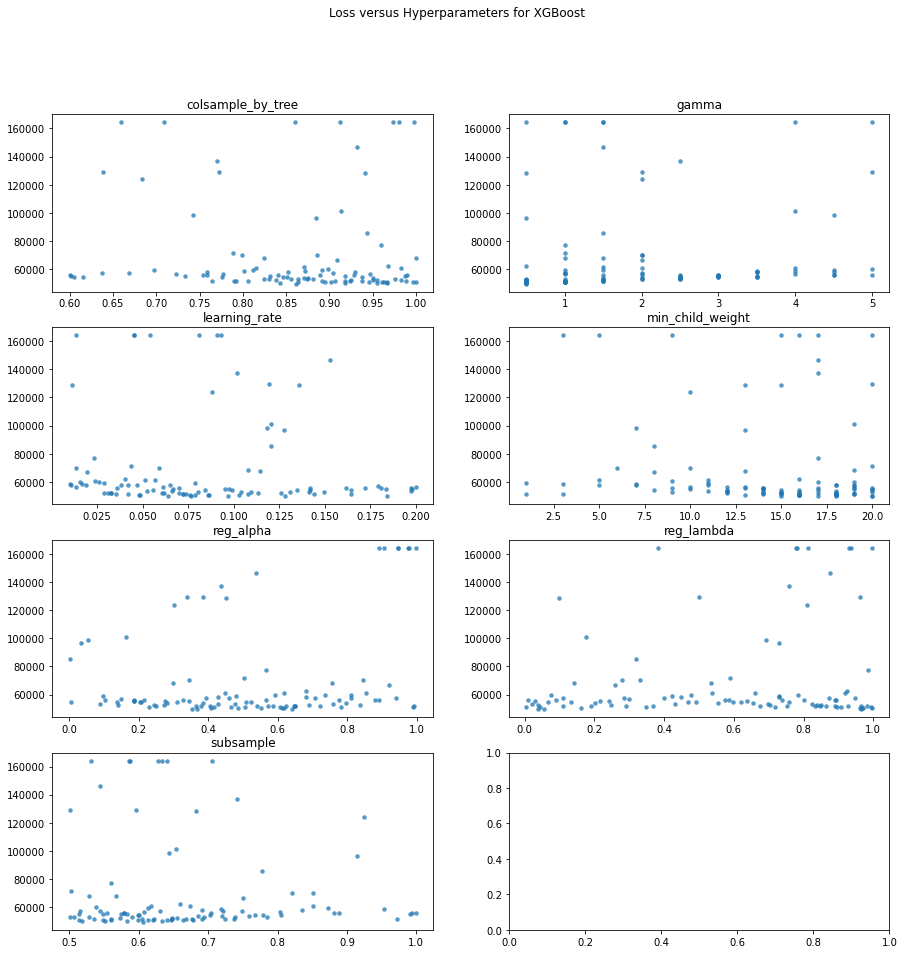

In [72]:
# Modified from: https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt
# Create subplots of all hyperparameter curves
xgb_parameters = ['colsample_by_tree', 'gamma',
              'learning_rate', 'min_child_weight',
              'reg_alpha', 'reg_lambda', 'subsample']    

cols = 2
f, axes = plt.subplots(nrows=4, ncols=cols, figsize=(15,15))
for i, val in enumerate(xgb_parameters):
    crow = int(i / 2)
    ccol = int(i % 2)
    xs = np.array([t['misc']['vals'][val] for t in xgb_trials.trials if len(t['misc']['vals'][val]) != 0]).ravel()
    ys = [-t['result']['loss'] for t in xgb_trials.trials if len(t['misc']['vals'][val]) != 0]
    new_xs = [x[0] for x in sorted(zip(xs, ys)) if x[0] is not None]
    new_ys = [abs(x[1]) for x in sorted(zip(xs, ys)) if x[0] is not None]
    ys = np.array(new_ys)
    axes[crow, ccol].scatter(new_xs, ys, s=20, linewidth=0.01, alpha=0.75)
    axes[crow, ccol].set_title(val)
    
f.suptitle('Loss versus Hyperparameters for XGBoost');
plt.show()

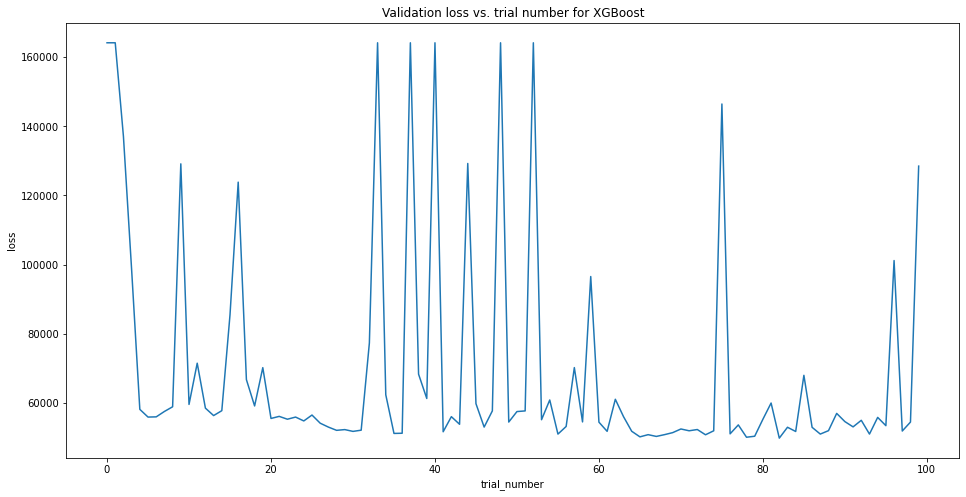

In [73]:
# Graphing loss vs trials
plt.figure(figsize=(16, 8))
sns.lineplot(x="trial_number", y="loss", data=xgb_trials_df).set_title("Validation loss vs. trial number for XGBoost");
plt.show()

In [74]:
# Sort the trials
xgb_trials_results = sorted(xgb_trials.results, key = lambda x: x['loss'])

# Convert to a dataframe
xgb_results = pd.DataFrame(xgb_trials_results)

# Save best parameters
best_xgb_estimators= xgb_results.loc[0,'estimators']
best_xgb_params= xgb_results.loc[0,'params']

# Use hyperparameters on test
best_xgb_model = xgb.XGBRegressor(n_estimators=best_xgb_estimators, n_jobs=-1, 
                                  random_state=rng, **best_xgb_params)

# Fit model
best_xgb_model.fit(X_train, y_train)

# Prediction
y_pred_xgb = best_xgb_model.predict(X_test)

# Results
print('Mean absolute error on best performing XGBoost Regressor: {}'.format(custom_mae_(y_test, y_pred_xgb)))

# Save best model
pickle.dump(best_xgb_model, open('xgb_model.pkl', 'wb'))

Mean absolute error on best performing XGBoost Regressor: 49486.449577981264


Here, we see that not only does the LightGBM regressor outperform the XGBoost Regressor at the test setting, but also computes the values much quicker.

# Conclusion and Comments

We saw that the average magnitude of error for our best performing regression models was around 45,000-50,000, which can be interpreted as follows: 

- *Our final XGBoost and LightGBM models' predictions of the value of a given house in Calgary with the same data above is expected to deviate from the actual sold price by `~$45-50K` on average.*

This is quite good considering all of the shortcomings of the methods employed, as well as the data itself.

Overall, this project was quite fullfilling. A lot of the problems I came across in this analysis can mostly be attributed to my lack of experience when dealing with DS problems. However, I feel like I learned quite a lot about the pipeline towards analyzing data. Hopefully, I can come back to this project in the future and pursue some of the work I left off.